# Activities Classification with Explainable AI (XAI)

<!-- ![title](Figure_2.png) -->

In [1]:
!pip install adversarial-robustness-toolbox --quiet

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

tf.compat.v1.disable_eager_execution()
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier


#Stops any warning
import warnings
warnings.filterwarnings('ignore')

## Stop the INFO level logging from printing
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

## Opening the files
Load the training/testing dataset from csv files
first column: ID
last column: the expected output, for example: 1, 2, 3, corresponds to one of 3 activities
+ 1: web browsing/file downloading
+ 2: online communication, like video call
+ 3: online video watching

In [ ]:
# Load the training/testing dataset from csv files
training_dataset = pd.read_csv("../output_train.csv", header=0, usecols=[*range(1,23)], sep=";")
testing_dataset = pd.read_csv("../output_test.csv", header=0, usecols=[*range(1,23)], sep=";")

# Remove missing values
training_dataset.dropna(axis = 0, inplace = True)
testing_dataset.dropna(axis = 0, inplace = True)

print("The shape of the training dataset: " + str(training_dataset.shape))
print("The shape of the testing dataset: " + str(testing_dataset.shape))

training_dataset.head()

The shape of the training dataset: (279, 22)
The shape of the testing dataset: (103, 22)


,session_time,%tcp_protocol,%udp_protocol,ul_data_volume,max_ul_volume,min_ul_volume,avg_ul_volume,std_ul_volume,%ul_volume,dl_data_volume,...,avg_dl_volume,std_dl_volume,%dl_volume,nb_uplink_packet,nb_downlink_packet,ul_packet,dl_packet,kB/s,nb_packet/s,output
0,4.999674,100.000000,0.000000,99090,54,54,54.000000,0.000000,1.652834,5896066,...,1564.358185,313.304936,98.347166,1835,3769,32.744468,67.255532,1199.109362,1120.873063,1
1,0.892125,100.000000,0.000000,32184,54,54,54.000000,0.000000,1.673617,1890837,...,1594.297639,601.903863,98.326383,596,1186,33.445567,66.554433,2155.550758,1997.477642,1
2,3.412767,99.857265,0.142735,77133,471,54,55.213314,18.696881,2.276791,3310662,...,1571.268154,562.653689,97.723209,1397,2107,39.868721,60.131279,992.682790,1026.732873,1
3,4.999285,99.888471,0.111529,142985,471,54,54.699694,14.495354,1.925924,7281243,...,1597.114060,649.341567,98.074076,2614,4559,36.442214,63.557786,1485.057968,1434.805182,1
4,1.682172,100.000000,0.000000,60534,54,54,54.000000,0.000000,1.571208,3792170,...,1645.907118,1250.277675,98.428792,1121,2304,32.729927,67.270073,2290.315058,2036.058071,1


In [ ]:
# Set of features in the dataset
features = list(testing_dataset.columns)
print(features[:-1])

['session_time', '%tcp_protocol', '%udp_protocol', 'ul_data_volume', 'max_ul_volume', 'min_ul_volume', 'avg_ul_volume', 'std_ul_volume', '%ul_volume', 'dl_data_volume', 'max_dl_volume', 'min_dl_volume', 'avg_dl_volume', 'std_dl_volume', '%dl_volume', 'nb_uplink_packet', 'nb_downlink_packet', 'ul_packet', 'dl_packet', 'kB/s', 'nb_packet/s']


In [ ]:
# Convert the expected output into arrays, e.g., 1 -> [1, 0, 0]
output_training = []
for i, val in enumerate(training_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_training.append(temp)

output_testing = []
for i, val in enumerate(testing_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_testing.append(temp)

# Remove the expected output column from the datasets
prep_training_dataset = training_dataset.drop(columns=['output'])
prep_testing_dataset = testing_dataset.drop(columns=['output'])

# Preprocessing the data
scaler = StandardScaler()
scaler.fit(prep_training_dataset)

# Apply transform to both the training/testing dataset.
X_train = scaler.transform(prep_training_dataset)
Y_train = np.array(output_training)

X_test = scaler.transform(prep_testing_dataset)
Y_test = np.array(output_testing)

print("Preprocessed inputs of the training dataset: " + str(X_train))
print("Preprocessed outputs of the training dataset: " + str(Y_train))

Preprocessed inputs of the training dataset: [[ 1.24949172  0.59231316 -0.58844871 ...  0.54501086  0.2208743
   0.62843195]
 [-0.8505485   0.59231316 -0.58844871 ...  0.4955518   0.97523057
   1.92817113]
 [ 0.43816388  0.5886868  -0.58480418 ...  0.04242978  0.0580633
   0.48885055]
 ...
 [-1.2056687   0.34743347 -0.34234218 ... -0.71477922 -0.56070378
  -0.41047599]
 [-0.89460259  0.58409106 -0.58018542 ...  0.10394211  0.44768975
   1.24034932]
 [-0.98176026  0.59231316 -0.58844871 ... -0.62260254  0.43111073
  -0.53651579]]
Preprocessed outputs of the training dataset: [[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0

# Model Creation

In [ ]:
# Define the Keras model
model = Sequential()
model.add(Dense(12, input_shape=(21,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

# Compile the Keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Put the classifier into ART wrapper
model = KerasClassifier(model=model, use_logits=False)

# Fit the Keras model on the dataset
model.fit(X_train, Y_train, nb_epochs=150, batch_size=10)

# Evaluate the Keras model
# _, accuracy = model.evaluate(X_train, Y_train)
# print('Accuracy: %.2f' % (accuracy*100))

predictions = model.predict(X_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(Y_test, axis=1)) / len(Y_test)
print("Accuracy on normal test examples: {}%".format(accuracy * 100))

Epoch 1/150
28/28 [==============================] - 1s 1ms/step - loss: 0.7330 - accuracy: 0.7921
Epoch 2/150
28/28 [==============================] - 0s 1ms/step - loss: 0.6127 - accuracy: 0.8136
Epoch 3/150
28/28 [==============================] - 0s 1ms/step - loss: 0.5291 - accuracy: 0.8244
Epoch 4/150
28/28 [==============================] - 0s 2ms/step - loss: 0.4612 - accuracy: 0.8280
Epoch 5/150
28/28 [==============================] - 0s 1ms/step - loss: 0.4008 - accuracy: 0.8351
Epoch 6/150
28/28 [==============================] - 0s 1ms/step - loss: 0.3450 - accuracy: 0.8530
Epoch 7/150
28/28 [==============================] - 0s 1ms/step - loss: 0.2967 - accuracy: 0.8602
Epoch 8/150
28/28 [==============================] - 0s 1ms/step - loss: 0.2567 - accuracy: 0.8602
Epoch 9/150
28/28 [==============================] - 0s 1ms/step - loss: 0.2257 - accuracy: 0.8674
Epoch 10/150
28/28 [==============================] - 0s 1ms/step - loss: 0.2018 - accuracy: 0.9176
Epoch 11/

# Generate Evasion attack dataset

In [ ]:
import timeit
generation_iters = 1000 # Number of Iterations run to calculate the time 

# Generate adversarial test examples
def generate_evasion_data():
    attack = FastGradientMethod(estimator=model, eps=0.4)
    x_test_adv = attack.generate(x=X_test, verbose=2)
    return attack, x_test_adv

# Time taken to generate adversarial samples
timetaken = timeit.timeit(lambda: generate_evasion_data(), number=generation_iters)
print("time taken (s):", timetaken)


In [ ]:
attack, x_test_adv = generate_evasion_data()
print(f"Length of evasion dataset: {len(x_test_adv)}")

predictions = model.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(Y_test, axis=1)) / len(Y_test)
print(f"Accuracy on adversarial test examples: {accuracy * 100:.2f}%")

## Resilience metric: Complexity

In [ ]:
# In white box attacks, complexity can be quantified as the computation (CPU/GPU usage), time required to generate an adversarial example.
complexity = (timetaken/generation_iters) / len(x_test_adv)
print(f"Complexity of generating adversarial test samples: {complexity * 10**6:.2f} microseconds")

## Resilience metric: Impact

In [ ]:
# computed as the ratio of adversarial examples Xa, generated from X, being successful at evading their target ML model F.
# impact = 1 - (np.sum(np.argmax(predictions, axis=1) == np.argmax(Y_test, axis=1))/len(Y_test))
impact = (np.sum(np.argmax(predictions, axis=1) != np.argmax(Y_test, axis=1))/len(Y_test))
print(f"Impact on the model by adversarial test examples: {impact * 100:.2f}%")

## Accountability metric: Currentness

In [ ]:
import shap
import lime

### SHAP

In [ ]:
# %%capture out
generation_iters = 2 # Number of Iterations run to calculate the time 
summary_size = 10 # Summarize the dataset for faster processing

# Function to generate explanations using SHAP
def generate_shap_explanations():
    X_train_summary = shap.kmeans(X_test, summary_size)
    explainer = shap.KernelExplainer(model.model.predict, X_train_summary)
    shap_contrib = explainer.shap_values(X_test)
    return attack, x_test_adv

timetaken_shap =  timeit.timeit(lambda: generate_shap_explanations(), number=generation_iters)
print("Time taken for SHAP:", timetaken_shap)

# Function for predictions
def generate_predictions():
    predictions = model.predict(X_test)
    return predictions

timetaken_preds =  timeit.timeit(lambda: generate_predictions(), number=generation_iters)
print("Time taken for Predictions:", timetaken_preds)

In [ ]:
currentness = timetaken_shap/timetaken_preds
print("Currentness of SHAP: {}".format(currentness))

### LIME

In [ ]:

from lime import lime_tabular
from matplotlib import pyplot as plt

generation_iters = 2

classes=['Web', 'Interactive', 'Video']
predict_fn_nn= lambda x: model.model.predict(x)

# Function to generate LIME explanations
def gen_local_expl(sample):
    explainer = lime_tabular.LimeTabularExplainer(
                            X_test, 
                            mode="classification", 
                            feature_names=features, 
                            feature_selection= 'auto',
                            kernel_width=None, 
                            discretize_continuous=True,
                            class_names=classes
                            )
    explanation = explainer.explain_instance(
                    sample, 
                    predict_fn_nn,
                    num_features=len(features),
                    top_labels=3
                    )
    return explainer, explanation

# Generate lime explanations to all the data points
def generate_lime_explanations():
    return [gen_local_expl(sample) for sample in X_test]

timetaken_lime =  timeit.timeit(lambda: generate_lime_explanations(), number=generation_iters)
print("Time taken for Lime:", timetaken_lime)

# Generate predictions
def generate_predictions():
    predictions = model.predict(X_test)
    return predictions

timetaken_preds =  timeit.timeit(lambda: generate_predictions(), number=generation_iters)
print("Time taken for Predictions:", timetaken_preds)

In [ ]:
currentness = timetaken_lime/timetaken_preds
print("Currentness of LIME: {}".format(currentness))

# Model Confusion Matrix

4/4 [==============================] - 0s 2ms/step
Wrong prediction at sample 58
Prediction: [0 0 0] but expected output: [0 1 0]
Wrong prediction at sample 61
Prediction: [0 0 1] but expected output: [0 1 0]
Wrong prediction at sample 71
Prediction: [1 0 0] but expected output: [0 0 1]
Wrong prediction at sample 75
Prediction: [0 0 0] but expected output: [0 0 1]
Wrong prediction at sample 83
Prediction: [1 0 0] but expected output: [0 0 1]
4/4 [==============================] - 0s 2ms/step
Confusion matrix: 
[[80  0  0]
 [ 0  6  1]
 [ 2  0 14]]
Number of wrong predictions: 5
Accuracy: 95.14563106796116%


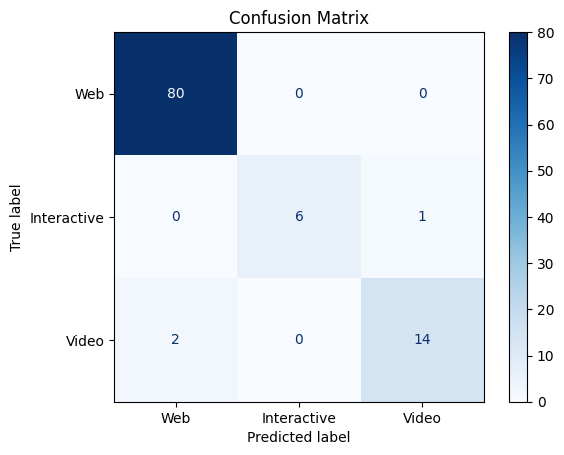

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Make class predictions with the model
predictions = (model.predict(X_test) > 0.5).astype(int)

nb_errors = 0
nb_tests = len(X_test)
errors = []
for i in range(0,len(X_test)):
	#print('%s (expected %s)' % (predictions[i].tolist(), Y_test[i].tolist()))
	if (predictions[i].tolist() != Y_test[i].tolist()):
		errors.append(i)
		nb_errors += 1

accuracy = (nb_tests - nb_errors) * 100 / nb_tests

for i in errors:
	print("Wrong prediction at sample " + str(i + 1))
	#print(X_test[i])
	print("Prediction: " + str(predictions[i]) + " but expected output: " + str(Y_test[i]))

Y_pred = model.predict(X_test)
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
print("Confusion matrix: \n" + str(cm))

labels = ["Web", "Interactive", "Video"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print("Number of wrong predictions: " + str(nb_errors))
print("Accuracy: " + str(accuracy) + "%")

# Explanations

## SHAP Kernel Explainer (Benign data)

4/4 [==============================] - 0s 2ms/step


Using 103 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/103 [00:00<?, ?it/s]

322/322 [==============================] - 1s 2ms/step


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


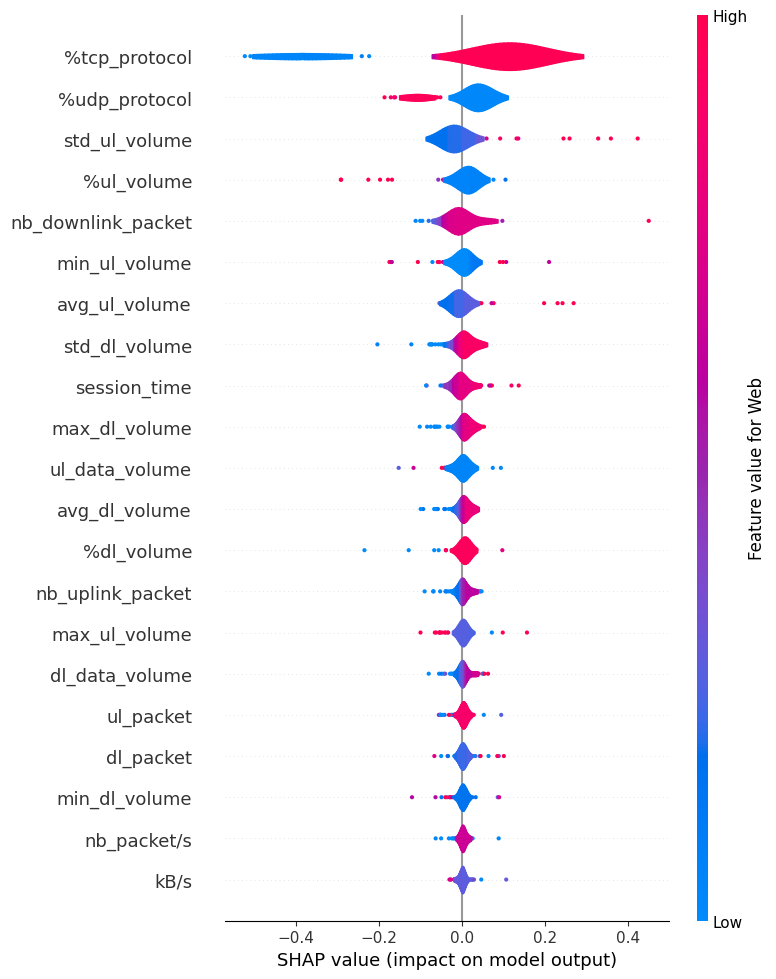

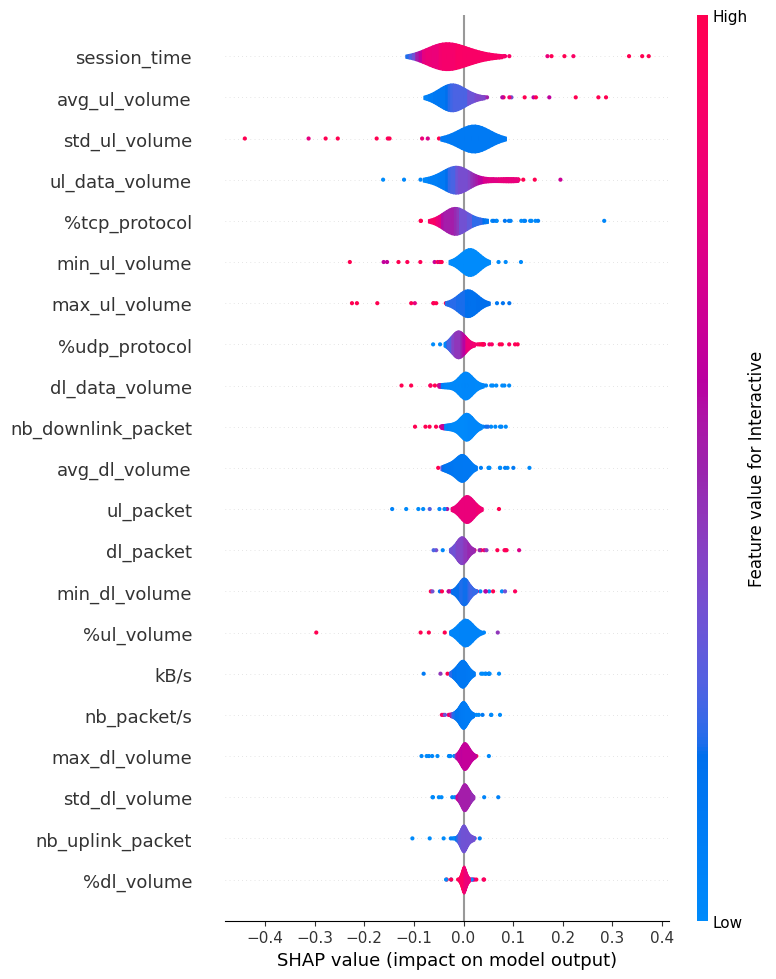

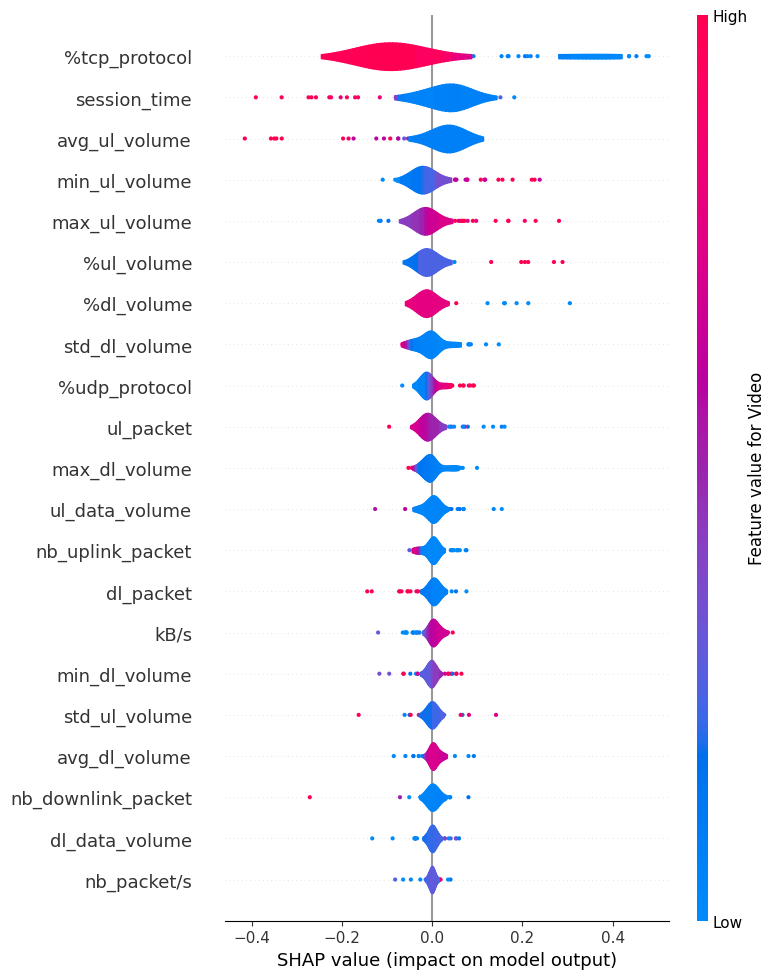

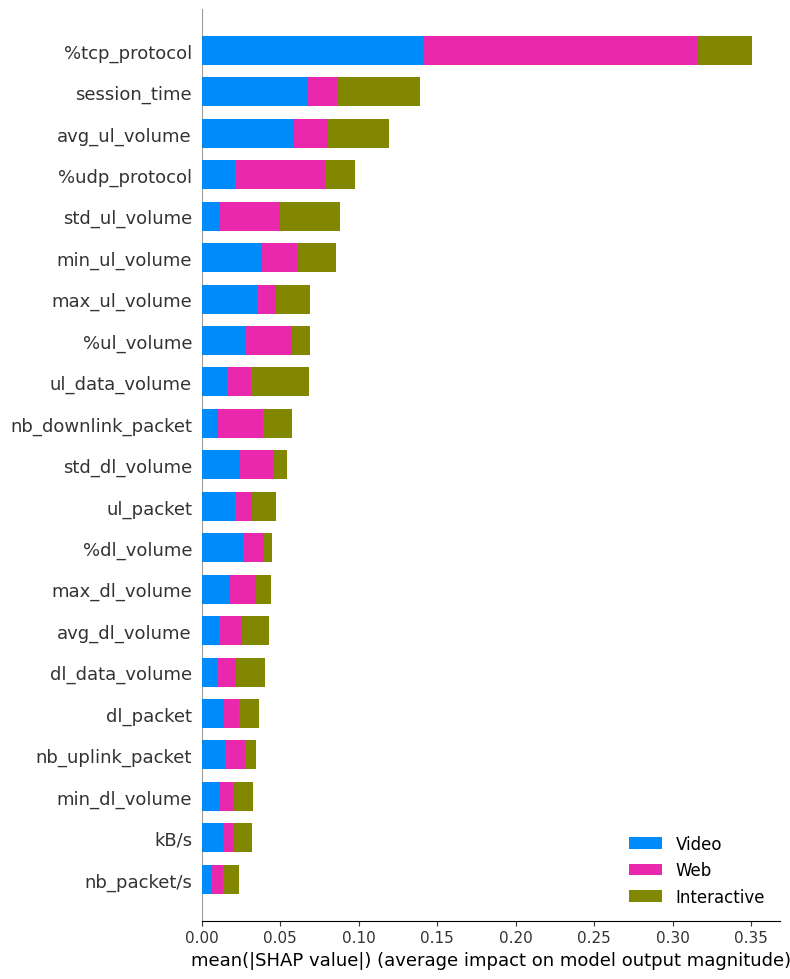

In [ ]:
from pydoc import classname
import warnings
import shap

classes=['Web', 'Interactive', 'Video']
explainer = shap.KernelExplainer(model.predict, X_test)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_test, nsamples=100)
#print(shap_values)

shap.summary_plot(shap_values[0], X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Web', plot_type="violin")
shap.summary_plot(shap_values[1], X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Interactive', plot_type="violin")
shap.summary_plot(shap_values[2], X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Video', plot_type="violin")

shap.summary_plot(shap_values, X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for all')

In [ ]:
shap.initjs()
#shap.force_plot(explainer.expected_value[0], shap_values[0], features=features[:-1])
#shap.force_plot(explainer.expected_value[1], shap_values[1], features=features[:-1])
shap.force_plot(explainer.expected_value[2], shap_values[2], features=features[:-1])

## SHAP Deep Explainer (Benign Test data)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


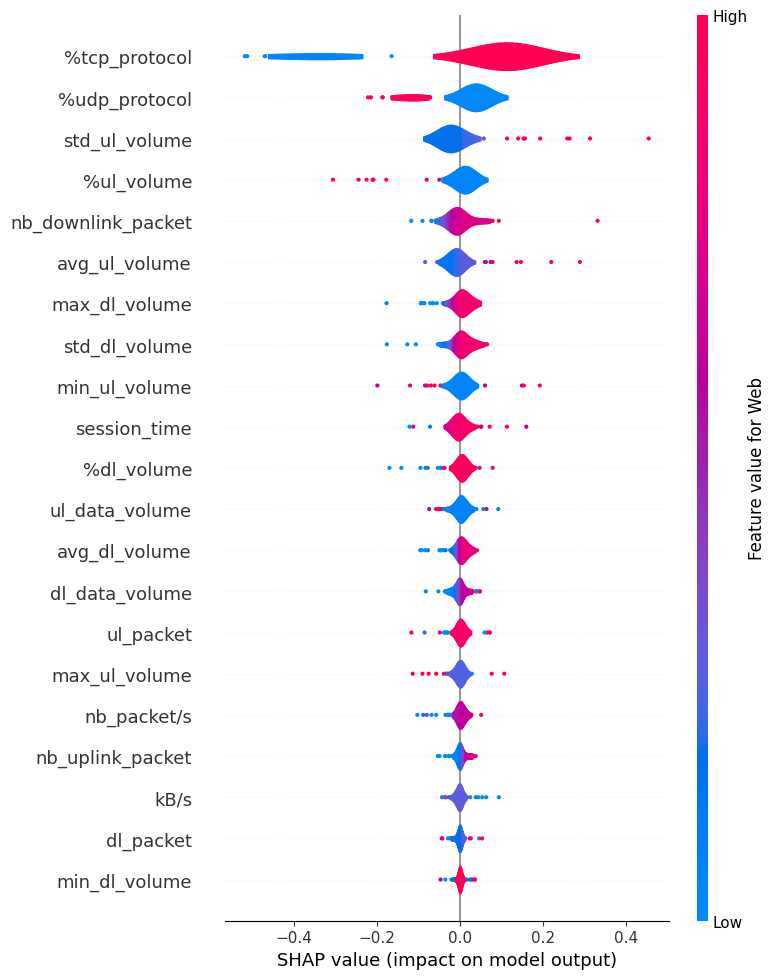

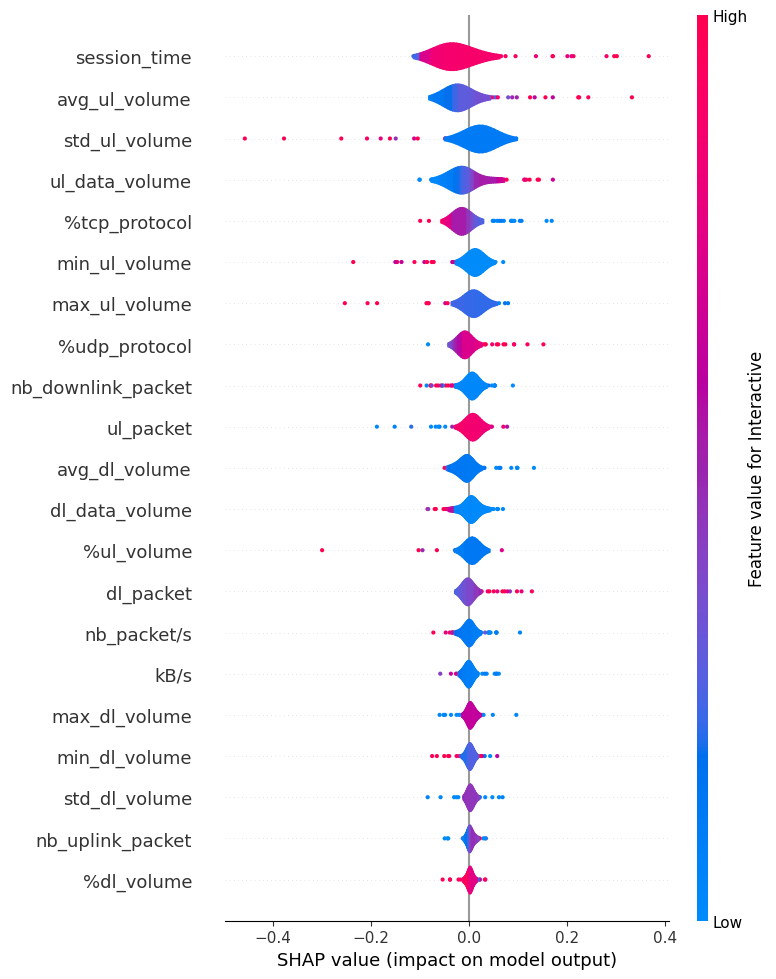

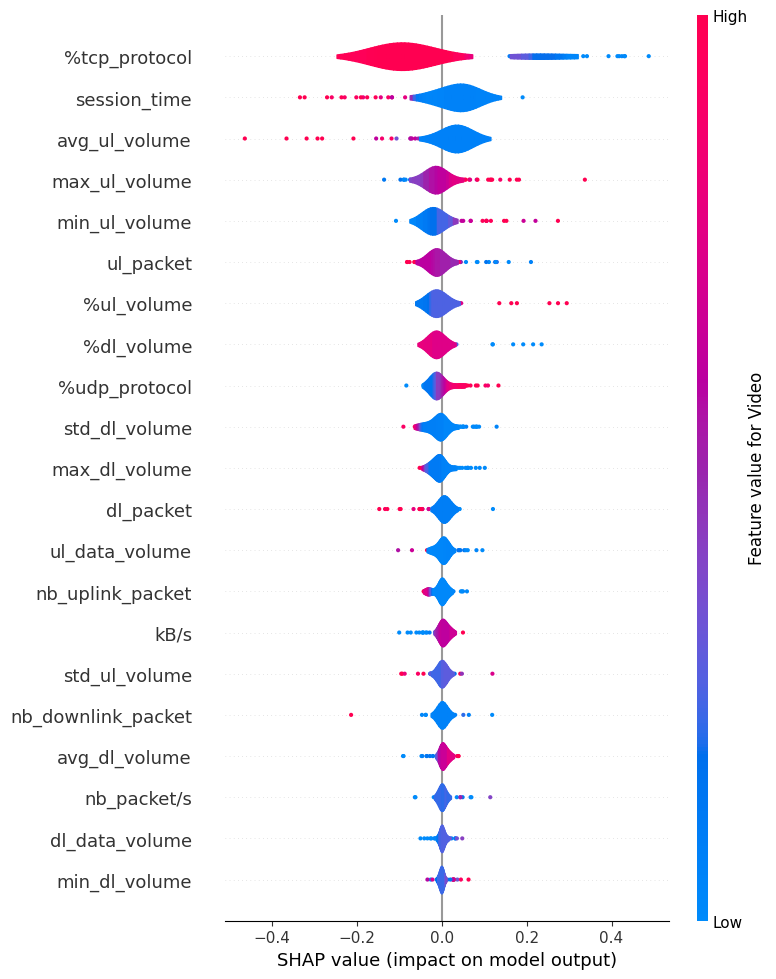

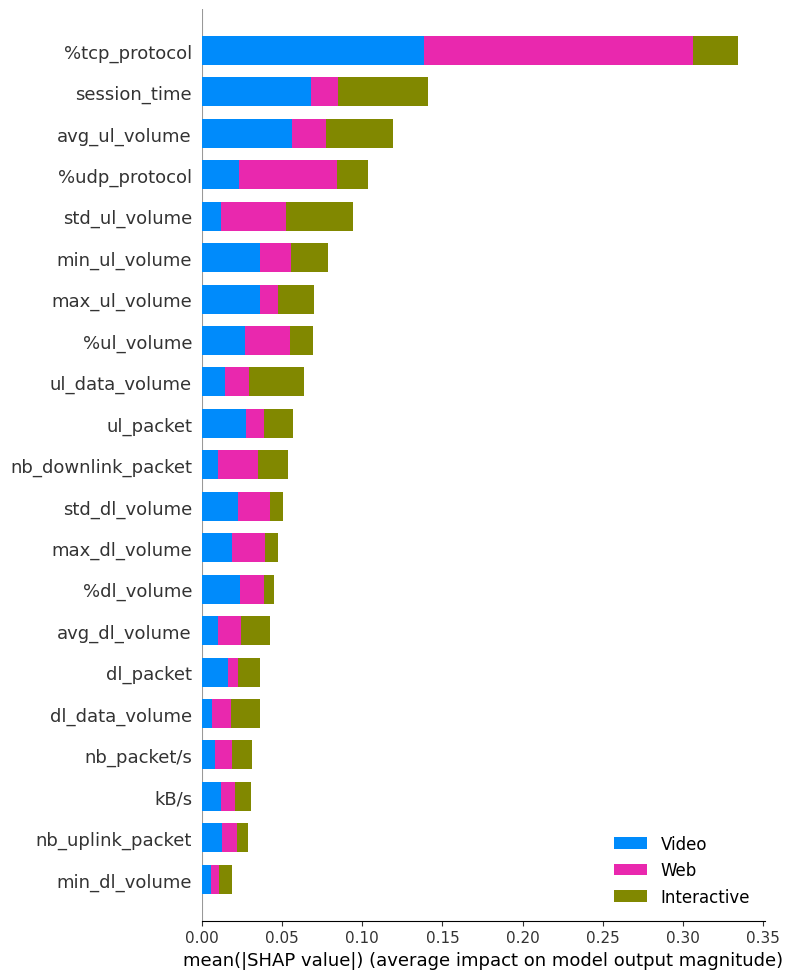

In [ ]:
from pydoc import classname
import warnings
import shap

classes=['Web', 'Interactive', 'Video']
dexplainer = shap.DeepExplainer(model, X_test)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    dshap_values = dexplainer.shap_values(X_test)
#print(shap_values)

#shap.summary_plot(dshap_values, X_test, feature_names=features, max_display=24, class_names=classes)



shap.summary_plot(shap_values[0], X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Web', plot_type="violin")
shap.summary_plot(shap_values[1], X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Interactive', plot_type="violin")
shap.summary_plot(shap_values[2], X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Video', plot_type="violin")

shap.summary_plot(shap_values, X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for all')

## LIME (Benign Test data)

In [ ]:
import lime
import random

from lime import lime_tabular
from matplotlib import pyplot as plt

#idx = random.randint(0, len(X_test))
idx = 78
print("Local interpretation of sample " + str(idx + 1))
print("Prediction : ", model.predict(X_test[idx].reshape(1,-1)))
print("Actual :     ", Y_test[idx])

classes=['Web', 'Interactive', 'Video']
predict_fn_nn= lambda x: model.predict(x)
explainer = lime_tabular.LimeTabularExplainer(X_test, mode="classification", feature_names=features, feature_selection= 'auto',
                                                kernel_width=None, discretize_continuous=True, class_names=classes)
explanation = explainer.explain_instance(X_test[idx], predict_fn_nn, num_features=len(features), top_labels=3)
#explanation.as_pyplot_figure()

plt.tight_layout()
explanation.show_in_notebook()

Local interpretation of sample 79
1/1 [==============================] - 0s 26ms/step
Prediction :  [[2.5561152e-02 2.1092779e-05 9.8776186e-01]]
Actual :      [0 0 1]
157/157 [==============================] - 0s 942us/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


<Figure size 640x480 with 0 Axes>

## SHAP Kernel Explainer (Attack test data)

In [ ]:
explainer = shap.KernelExplainer(model.predict, x_test_adv)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(x_test_adv, nsamples=100)
np.shape(shap_values)

In [ ]:


shap.summary_plot(shap_values[0], x_test_adv, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Web', plot_type="violin")
shap.summary_plot(shap_values[1], x_test_adv, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Interactive', plot_type="violin")
shap.summary_plot(shap_values[2], x_test_adv, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Video', plot_type="violin")

shap.summary_plot(shap_values, x_test_adv, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for all')

In [ ]:
shap.initjs()
#shap.force_plot(explainer.expected_value[0], shap_values[0], features=features[:-1])
#shap.force_plot(explainer.expected_value[1], shap_values[1], features=features[:-1])
shap.force_plot(explainer.expected_value[2], shap_values[2], features=features[:-1])

## LIME explainer (Attack test data)

In [ ]:
#idx = random.randint(0, len(X_test))
idx = 78
print("Local interpretation of sample " + str(idx + 1))
print("Prediction : ", model.predict(x_test_adv[idx].reshape(1,-1)))
print("Actual :     ", Y_test[idx])

classes=['Web', 'Interactive', 'Video']
predict_fn_nn= lambda x: model.predict(x)
explainer = lime_tabular.LimeTabularExplainer(x_test_adv, mode="classification", feature_names=features, feature_selection= 'auto',
                                                kernel_width=None, discretize_continuous=True, class_names=classes)
explanation = explainer.explain_instance(x_test_adv[idx], predict_fn_nn, num_features=len(features), top_labels=3)
#explanation.as_pyplot_figure()

plt.tight_layout()
explanation.show_in_notebook()